In [1]:
import pandas as pd
import os
from scipy.io import loadmat
from cnns.utils import cnn_utils as cu
from cnns.utils import imagenet_utils as imu
import numpy as np
import json

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [13]:
evaluation_dir = '/Users/babasarala/Desktop/evaluation'
cnn_dir = '/Users/babasarala/repos/cnns'
image_url_files_dir = os.path.join(evaluation_dir, 'image_url_files')
mat_filepath = '%s/ILSVRC2013_devkit/data/meta_clsloc.mat'% evaluation_dir
ground_truth_filepath = os.path.join(evaluation_dir, 'raw_images/ILSVRC2013_clsloc_validation_ground_truth.txt')
results_dirpath = os.path.join(evaluation_dir, 'ILSVRC2012_val')
collapse_filepath = os.path.join(cnn_dir, 'config/imagenet_cats_2016_12_07.json')

In [7]:
# recover the label names
mappings = json.load(open(collapse_filepath, 'rb'))
cat_names = set([])
for imagenet_label, collapsed_cat in mappings.iteritems():
    cat_names.add(collapsed_cat)
cat_names = list(cat_names)

# Analyzing the ILSVR2012 Validation set with the different Neural Networks

In [11]:
def load_validation_ground_truth(ground_truth_filepath, mat_filepath, collapse_filepath=None):
    ground_truth_idxs = []
    img_urls = []
    with open(ground_truth_filepath, 'rb') as f:
        cnt = 0
        for idx, lines in enumerate(f):
            num_zeros = 8 - len(str(idx))
            img_urls.append('ILSVRC2012_val_%s%i.JPEG'%(''.join(['0']*num_zeros), idx+1))
            ground_truth_idxs.append(int(lines))
    ilsvrc_id_cats = imu.load_imagenet_cats_from_mat(mat_filepath)
    # k->v : image idx -> v
    ground_truth_cats = {img_url: ilsvrc_id_cats[img_idx]
                           for img_idx, img_url in zip(ground_truth_idxs, img_urls)}
    if collapse_filepath:
        tfm_fcn = cu.get_tfm_fcn_from_json(collapse_filepath)
        return {img_idx: tfm_fcn(ground_truth_cat)
                for img_idx, ground_truth_cat in ground_truth_cats.iteritems()}

    return ground_truth_cats

In [14]:
ground_truth_labels = load_validation_ground_truth(ground_truth_filepath, 
                                                   mat_filepath, 
                                                   collapse_filepath=None)

In [ ]:
alexnet_results_dirpath = os.path.join(results_dirpath, 'AlexNet_full')
vgg_results_dirpath = os.path.join(results_dirpath, 'VGG_full')
googlenet_results_dirpath = os.path.join(results_dirpath, 'GoogLeNet_full')

all_pred_labels = {'AlexNet': imu.combine_checkpoint_results(alexnet_results_dirpath),
               'VGG': imu.combine_checkpoint_results(vgg_results_dirpath),
               'GoogLeNet': imu.combine_checkpoint_results(googlenet_results_dirpath)}

In [10]:
model_type = 'AlexNet'
pred_labels = all_pred_labels[model_type]
print 'Top-1 Accuracy for %s: %.2f%%'%(model_type, 100.*imu.compute_top_k_acc(ground_truth_labels, 
                                                                              pred_labels, 
                                                                              k=1))
print 'Top-5 Accuracy for %s: %.2f%%'%(model_type, 100.*imu.compute_top_k_acc(ground_truth_labels, 
                                                                              pred_labels, 
                                                                              k=5))

Top-1 Accuracy for AlexNet: 56.03%
Top-5 Accuracy for AlexNet: 79.39%


In [7]:
inception_v3_results_dirpath = os.path.join(results_dirpath, 'GoogLeNetv3_full')
pred_labels = imu.combine_checkpoint_results(inception_v3_results_dirpath)

In [8]:
model_type = 'GoogLeNet inception v3'
print 'Top-1 Accuracy for %s: %.2f%%'%(model_type, 100.*imu.compute_top_k_acc(ground_truth_labels, 
                                                                              pred_labels, 
                                                                              k=1))
print 'Top-5 Accuracy for %s: %.2f%%'%(model_type, 100.*imu.compute_top_k_acc(ground_truth_labels, 
                                                                              pred_labels, 
                                                                              k=5))

Top-1 Accuracy for GoogLeNet inception v3: 1.43%
Top-5 Accuracy for GoogLeNet inception v3: 7.32%


In [14]:
import pickle as pkl
d = pkl.load(open('/Users/babasarala/Desktop/results/ILSVRC2012_GoogLeNetv3_id_100.p', 'rb'))

In [16]:
d1 = pkl.load(open('/Users/babasarala/Desktop/evaluation/ILSVRC2012_val/GoogLeNetv3_full/ILSVRC2012_GoogLeNetv3_id_100.p'))

# Analyzing the ILSVR2012 Validation set with refactored classes

In [12]:
prune_filepath = os.path.join(cnn_dir, 'config/image_net_categories_animals_screenshots_devices_2016_05_04.json')
ground_truth_labels = imu.load_validation_ground_truth(ground_truth_filepath, 
                                                       mat_filepath, 
                                                       prune_filepath=prune_filepath)

In [ ]:
alexnet_results_dirpath = os.path.join(results_dirpath, 'AlexNet_pruned_custom')
vgg_results_dirpath = os.path.join(results_dirpath, 'VGG_pruned_custom')
googlenet_results_dirpath = os.path.join(results_dirpath, 'GoogLeNet_pruned_custom')

all_pred_labels = {'AlexNet': imu.combine_checkpoint_results(alexnet_results_dirpath),
               'VGG': imu.combine_checkpoint_results(vgg_results_dirpath),
               'GoogLeNet': imu.combine_checkpoint_results(googlenet_results_dirpath)}

In [15]:
# recover the label names
prune_mappings = json.load(open(prune_filepath, 'rb'))
label_names = set([])
for imagenet_label, pruned_label in prune_mappings.iteritems():
    label_names.add(pruned_label)
label_names = list(label_names)

In [13]:
model_type = 'GoogLeNet'
pred_labels = all_pred_labels[model_type]
print 'Accuracy for %s on custom classes: %.2f%%'%(model_type, 
                                                   100.*imu.compute_top_k_acc(ground_truth_labels, 
                                                                              pred_labels, 
                                                                              k=1))

NameError: name 'all_pred_labels' is not defined

In [20]:
conf_mat, clf_report = imu.compute_metrics(ground_truth_labels, pred_labels, labels=label_names)
print label_names
print clf_report

[u'wildlife', u'other', u'screenshots', u'devices', u'furry_friends']
             precision    recall  f1-score   support

   wildlife       0.97      0.96      0.97     13600
      other       0.97      0.98      0.98     29100
screenshots       0.84      0.86      0.85        50
    devices       0.80      0.73      0.76      1000
furry_friends       0.96      0.98      0.97      6250

avg / total       0.97      0.97      0.97     50000



In [29]:
mappings = {}
for idx, label in enumerate(label_names):
    mappings[idx] = label
    mappings[label] = idx

In [30]:
mappings

{0: u'wildlife',
 1: u'other',
 2: u'screenshots',
 3: u'devices',
 4: u'furry_friends',
 u'devices': 3,
 u'furry_friends': 4,
 u'other': 1,
 u'screenshots': 2,
 u'wildlife': 0}

In [31]:
pred_labels[1]

[(u'wildlife', 0.92914779542479664),
 (u'other', 0.054843743978835846),
 (u'screenshots', 0.0001346807403024286),
 (u'devices', 0.0016641851275380759),
 (u'furry_friends', 0.013655060049131862)]

In [32]:
y_true = np.zeros((len(mappings)/2, len(ground_truth_labels)))
for idx, ground_truth_label in ground_truth_labels.iteritems():
    y_true[mappings[ground_truth_label], idx-1] = 1
y_true = y_true.T

In [33]:
y_prob = np.zeros((len(mappings)/2, len(pred_labels)))
for idx, pred_label in pred_labels.iteritems():
    for tup in pred_label:
        y_prob[mappings[tup[0]],idx-1] = tup[1]
y_prob = y_prob.T

In [34]:
y_true.shape

(50000, 5)

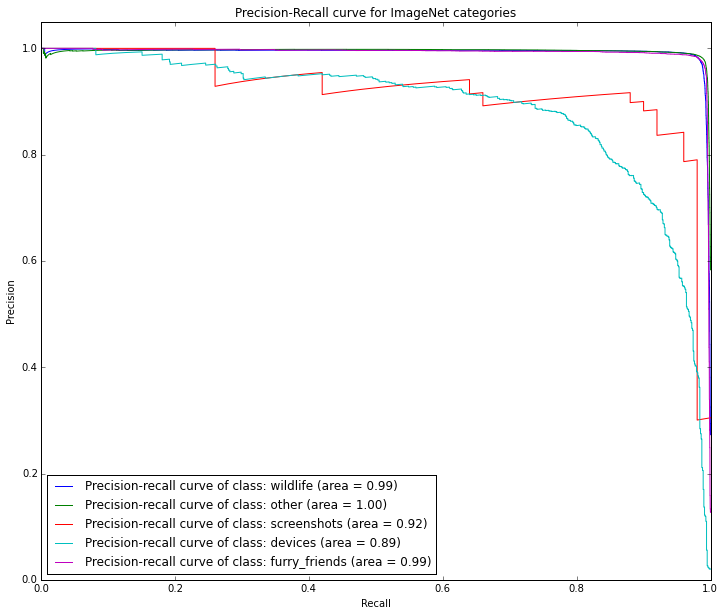

In [35]:
# Compute Precision-Recall and plot curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

precision = dict()
recall = dict()
average_precision = dict()
n_classes = len(label_names)
for i in range(n_classes):
    precision[i], recall[i], threshs = precision_recall_curve(y_true[:, i],
                                                        y_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_prob[:, i])

# Plot Precision-Recall curve for each class
f = plt.figure(figsize=(12,10))
plt.clf()
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class: {0} (area = {1:0.2f})'
                   ''.format(mappings[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for ImageNet categories')
plt.legend(loc="lower left")
plt.show()

In [27]:
inception_v3_results_dirpath = os.path.join(results_dirpath, 'GoogLeNetv3_pruned_custom')
pred_labels = imu.combine_checkpoint_results(inception_v3_results_dirpath)
print 'Accuracy for %s on custom classes: %.2f%%'%(model_type, 
                                                   100.*imu.compute_top_k_acc(ground_truth_labels, 
                                                                              pred_labels, 
                                                                              k=1))

Accuracy for GoogLeNet on custom classes: 98.05%


In [28]:
conf_mat, clf_report = imu.compute_metrics(ground_truth_labels, pred_labels, labels=label_names)
print label_names
print clf_report

[u'wildlife', u'other', u'screenshots', u'devices', u'furry_friends']
             precision    recall  f1-score   support

   wildlife       0.99      0.98      0.98     13600
      other       0.98      0.99      0.98     29100
screenshots       0.80      0.96      0.87        50
    devices       0.88      0.78      0.83      1000
furry_friends       0.98      0.98      0.98      6250

avg / total       0.98      0.98      0.98     50000

